In [1]:
%pylab notebook --no-import-all
%matplotlib notebook
from astropy import units as u
from astropy import constants as const
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import psalib as pl

Populating the interactive namespace from numpy and matplotlib


In [36]:
PI     = np.pi
TWO_PI = 2*PI 

g      = const.g0
R      = const.R

In [160]:
dx   = 0.2 * u.cm
L    = 90.0*u.cm

sel_freqs = np.array([600, 1000, 1200, 1500])

# ALL IN CM
x600  = np.array([10.3, 38.1, 67.8])
x1k   = np.array([6.2, 23.2, 40.7, 58.2, 75.1])
x1_2k = np.array([4.1, 18.3, 32.9, 46.8, 61.2, 75.7])
x1_5k = np.array([1.8, 13.7, 25.2, 36.6, 47.6, 59.0, 72.4])

M     = ((2*15.999 + 2*14.007) * (u.g / u.mol)).to(u.kg / u.mol)
gamma = 1.4

# temperature
T     = [21.6 * u.Celsius, 0.1 * u.Celsius]

# distance for air
dis   = (160*u.cm).to(u.m)

# Times for section 6
t1    = np.array([17.6, 17.9, 42.5, 41.9]) * 0.001
t2    = np.array([22.4, 22.8, 47.7, 46.8]) * 0.001
dt    = t2 - t1

# time for Helium (ish)
t1_he = 0.0503 - 0.0431
t2_he = 0.0511 - 0.0499
t3_he = 0.0504 - 0.0491
t4_he = 0.0514 - 0.0500

# distances for Helium
d1_he = (2*(80-32)) / 100
d2_he = (2*(80-32)) / 100
d3_he = (2*(80-31)) / 100
d4_he = (2*(80-29)) / 100

In [172]:
def lamda(arr):
    if len(arr) < 3:
        raise Exception('Not enough data')
    
    data = np.zeros(len(arr) - 2)
    i    = 0
    
    while (i + 2) < len(arr):
        data[i] = arr[i+2] - arr[i]
        i += 1
    
    mean  = np.mean(data)
    sdata = np.sqrt(2*(dx.value)**2) # DEFAULT
    
    if len(data) > 1:
        sdata = np.std(data)
    
    return [mean * u.cm, sdata * u.cm]

def speed(lams, freqs):
    assert len(lams) is len(freqs), 'Array dimensions do not match to determine speed of sound'
    
    # convert to m
    lams_primed = np.zeros(len(lams))
    i           = 0
    
    while (i < len(lams_primed)):
        lams_primed[i] = lams[i][0].to(u.m).value
        i += 1
        
    # find speed of sound
    sound = lams_primed * freqs
    
    return sound

def speed_temp(temp):
    v  = (331.5 * (u.m / u.s)) + (.606 * (u.m / (u.s * u.Celsius)))*temp[0]
    dv = (.606 * (u.m / (u.s * u.Celsius)))*temp[1]
    
    return [v, dv]

def speed_time(times, l):
    v = l.value / times
    return v

def speed_helium(temp):
    gamma_he = 5.19 / 3.12
    M_he     = (4.002602 * (u.g / u.mol)).to(u.kg / u.mol)
    
    A        = (gamma_he * (R.to(u.kg*(u.m**2)*(u.s**-2)*(u.mol **-1)*(u.K**-1)))) / M_he
    v_helium = np.sqrt(A*((temp[0].value + 273.15) * u.K))
    return v_helium

def normal_wavelengths(n, l):
    _l  = l.to(u.m).value
    arr = np.zeros(n)
    i   = 0
    
    while i < n:
        arr[i] = (4*_l) / (2*(i+1) - 1)
        i += 1
    
    return arr

<IPython.core.display.Javascript object>


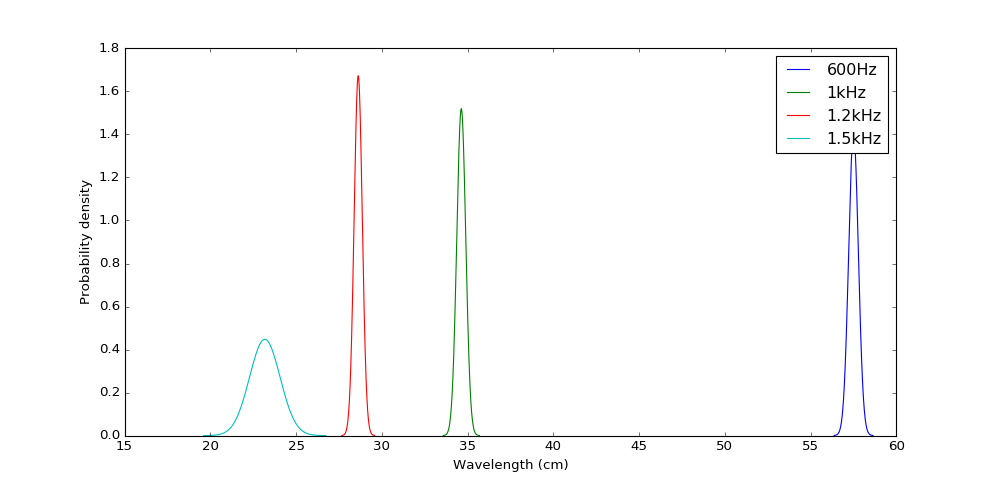

In [25]:
l600  = lamda(x600)
l1k   = lamda(x1k)
l1_2k = lamda(x1_2k)
l1_5k = lamda(x1_5k)

def _get_plot(lam):
    xbar = lam[0].value
    s    = lam[1].value
    
    x    = np.linspace(xbar - 4*s, xbar + 4*s, 1000)
    y    = mlab.normpdf(x, xbar, s)
    
    return [x, y]

x,y = _get_plot(l600)
plt.plot(x, y, label='600Hz')

x,y = _get_plot(l1k)
plt.plot(x, y, label='1kHz')

x,y = _get_plot(l1_2k)
plt.plot(x, y, label='1.2kHz')

x,y = _get_plot(l1_5k)
plt.plot(x, y, label='1.5kHz')

plt.xlabel('Wavelength (cm)')
plt.ylabel('Probability density')
plt.legend(loc='upper right')

In [108]:
arr  = speed([l600, l1k, l1_2k, l1_5k], sel_freqs)
true = speed_temp(T)

mu   = np.mean(arr)
s    = np.std(arr)

x_wave = np.linspace(mu - 4*s, mu + 4*s, 1000)
y_wave = mlab.normpdf(x_wave, mu, s)
plt.plot(x_wave, y_wave, label='Measured from wavelengths')
# plt.hist(arr, bins=3, normed=True, alpha=0.3)

plt.axvline(true[0].value, ls='--', color='g', alpha=0.5, label='Theory')

plt.xlabel('Speed (m/s)')
plt.ylabel('Probability density')
plt.legend(loc='upper left')

print('Wavelengths: %3.3f±%1.3f m/s' % (mu, s))

Wavelengths: 345.633±1.558 m/s


<IPython.core.display.Javascript object>


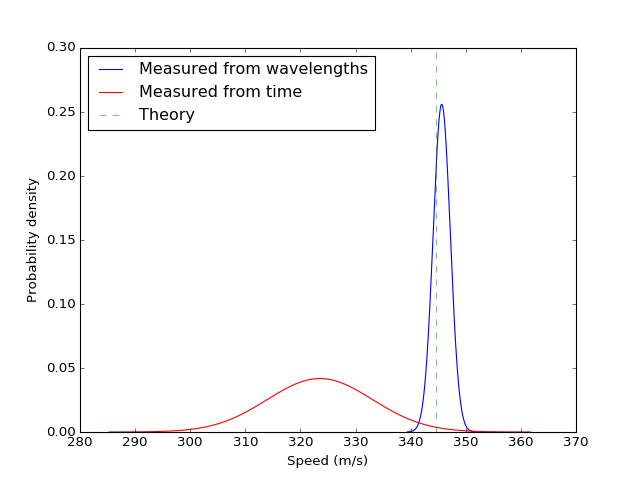

Time: 323.522±9.552 m/s
Theory: 344.590±0.061 m/s


In [112]:
v_time = speed_time(dt, dis)

mu     = np.mean(v_time)
s      = np.std(v_time)

x_time = np.linspace(mu-4*s, mu+4*s, 1000)
y_time = mlab.normpdf(x_time, mu, s)

plt.plot(x_wave, y_wave, label='Measured from wavelengths')
plt.plot(x_time, y_time, label='Measured from time', color='r')

plt.axvline(true[0].value, ls='--', color='g', alpha=0.5, label='Theory')

plt.xlabel('Speed (m/s)')
plt.ylabel('Probability density')
plt.legend(loc='upper left')

print('Time: %3.3f±%1.3f m/s\nTheory: %3.3f±%0.3f m/s' % (mu, s, true[0].value, true[1].value))

<IPython.core.display.Javascript object>


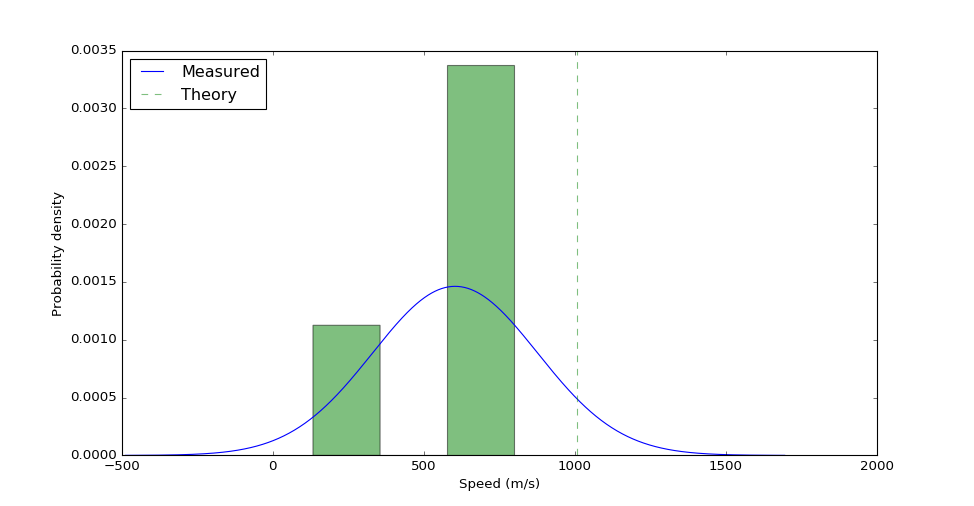

In [144]:
# helium measured
he_time  = np.array([t1_he, t2_he, t3_he, t4_he])
he_dis   = np.array([d1_he, d2_he, d3_he, d4_he])

he_speed = he_dis / he_time

he_mu    = np.mean(he_speed)
he_s     = np.std(he_speed)

he_x     = np.linspace(he_mu - 4*he_s, he_mu + 4*he_s, 1000)
plt.plot(he_x, mlab.normpdf(he_x, he_mu, he_s), label='Measured')
plt.hist(he_speed, bins=3, normed=true, alpha=0.5)

plt.axvline(speed_helium(T).value, ls='--', color='g', alpha=0.5, label='Theory')
# that's one helluvan uncertainty Jack

plt.xlabel('Speed (m/s)')
plt.ylabel('Probability density')
plt.legend(loc='upper left')

<IPython.core.display.Javascript object>


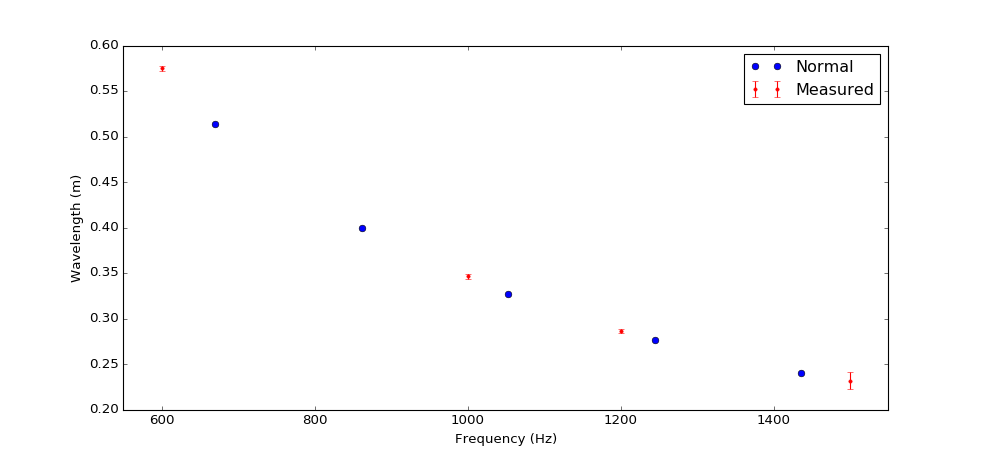

In [171]:
norm_lens  = normal_wavelengths(8, L)[3:]
norm_freqs = true[0].value / lens

measured_lams = np.array([l600[0].to(u.m).value, l1k[0].to(u.m).value, l1_2k[0].to(u.m).value, l1_5k[0].to(u.m).value])
errlams = np.array([l600[1].to(u.m).value, l1k[1].to(u.m).value, l1_2k[1].to(u.m).value, l1_5k[1].to(u.m).value])

plt.plot(norm_freqs, norm_lens, 'bo', label='Normal')
plt.errorbar(sel_freqs, measured_lams, yerr=errlams, fmt='r.', label='Measured')

plt.xlim(550, 1550)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Wavelength (m)')
plt.legend(loc='upper right')